## Pair GGL with near-identical deflectors to make PDSPLs

Here we prepare 3 different sets of PDSPL samples by pairing GGL systems with near-identical deflectors from the SLSim LSST GGL catalog. We then analyze the paired systems.

In [1]:
# Standard imports
import corner
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import pickle

# Astropy imports
from astropy.table import Table

# Lenstronomy, HierArc imports
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from pdspl_analysis_utils import kdtree_matching_n_dim, get_pairs_table_PDSPL, normalize_data
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.style.use("../paper_style.mplstyle")

%load_ext autoreload
%autoreload 2

In [2]:
FIGURES_DIR = "../figures/"

## Prepare LSST like samples for Single Visit, Y10, and 4MOST 

In [3]:
########################################################
### Load the GGL data table and apply selection cuts!
########################################################

sky_area = "20000.0"
GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS.fits", format='fits')
# GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS_UNIQUE_DEFLECTORS.fits", format='fits')

contrast_mask = np.zeros(len(GGL_data_table), dtype=bool)
# ps_magnification_mask = np.zeros(len(GGL_data_table), dtype=bool)
for i in range(len(GGL_data_table)):
    
    # contrast mask
    all_vals = GGL_data_table['contrast_ratio_i'][i]
    all_vals = all_vals[~np.isnan(all_vals)]
    # get linear scale values
    all_vals = 10**(-0.4 * all_vals)
    contrast_mask[i] = np.all(all_vals > 2) # all images should have contrast ratio > 2

    # point source magnification mask
    # ps_magnifications = GGL_data_table['ps_magnification'][i]
    # ps_magnifications = ps_magnifications[~np.isnan(ps_magnifications)]
    # high_mag = np.any(np.abs(ps_magnifications) > 3)
    # ps_magnification_mask[i] = high_mag

# add a column for r_band lensed source magnitude
GGL_data_table['mag_S_r_lensed'] = GGL_data_table['mag_S_r'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))
GGL_data_table['mag_S_i_lensed'] = GGL_data_table['mag_S_i'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))

# add g-r and r-i colors for deflector
GGL_data_table['color_D_gr'] = GGL_data_table['mag_D_g'] - GGL_data_table['mag_D_r']
GGL_data_table['color_D_ri'] = GGL_data_table['mag_D_r'] - GGL_data_table['mag_D_i']

# add log columns
GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

GGL_data_table = GGL_data_table[ 
                                # (GGL_data_table['mag_D_i'] >= 19) & # optional, but reasonable for realistic deflectors
                                (GGL_data_table['mag_S_i_lensed'] < 28)
                                & (GGL_data_table['mag_D_i'] < 28)
                                & (contrast_mask)
                                & (np.abs(GGL_data_table['es_magnification']) > 3)
                                # & (ps_magnification_mask)
                                ]

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,R_e_arcsec,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2,num_images,contrast_ratio_i,contrast_ratio_r,contrast_ratio_g,contrast_ratio_z,contrast_ratio_y,ps_magnification,es_magnification,mag_S_r_lensed,mag_S_i_lensed,color_D_gr,color_D_ri,log_R_e_kpc,log_Sigma_half_Msun/pc2,log_sigma_v_D
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64
4,0.5499245697508854,3.083792779719749,0.960186172912658,221.0307546027853,346389050199.0108,26.334201697535665,26.483064631942394,26.586765632504164,26.222559566632466,26.263721326971318,19.814272472224467,20.769139379617073,22.293623030711792,19.432825952512587,19.194705538501523,0.8826852911341407,0.3089511566939957,-0.0021142501897284988,0.3089583908496784,2.155097852999678,5.659052108920743,0.8826852911341407,4386.881809786243,24.571690111285648,2,[-3.57631611 -1.73145897 nan nan],[-4.38232008 -2.53746294 nan nan],[-5.80310273 -3.9582456 nan nan],[-3.30651172 -1.46165458 nan nan],[-3.02722954 -1.18237241 nan nan],[ 1.76287067 -3.21420276 nan nan],4.807546970783347,24.77825579173455,24.629392857327822,1.5244836510947195,0.9548669073926064,0.7527436929656415,3.6421559339150673,2.3444527063774756
5,0.7607959249289795,2.2091343439755375,1.009929393948074,262.02978339713366,552152068690.0726,26.16607662369585,26.36907155870925,26.77863580083538,25.875740482480104,25.521410984405733,20.63147160824859,21.89617520351898,23.46255259214415,20.041828409777438,19.740270235219384,1.1188468422614797,0.3376417809713386,0.21287068930628025,0.3991439622783092,2.0500098766142747,8.25335131874696,1.1188468422614797,3799.457501646817,26.230628023922723,4,[-4.56879073 -3.99227144 -3.28184554 -2.52559194],[-5.63049939 -5.05398011 -4.3435542 -3.5873006 ],[-6.78731253 -6.21079325 -5.50036735 -4.74411375],[-4.26948367 -3.69296439 -2.98253848 -2.22628488],[-4.32225499 -3.74573571 -3.03530981 -2.27905621],[ 2.21746262 3.8713244 -2.59653263 -0.754455 ],9.932277652048256,23.876449429844907,23.673454494831507,1.5663773886251704,1.2647035952703902,0.9166303320287469,3.5797215911271874,2.418350657846043
6,0.3935362656932773,2.572335218318845,0.5833577524380458,165.18696802132712,131306848926.99675,27.00052642679413,27.32362211701996,27.65639555202197,26.84561197621227,26.549939827706737,19.880775143092013,20.496084369613154,21.99951260452283,19.55136028712953,19.37281970199086,0.6623664693653802,-7.797808866027306e-05,-0.0016515287088479755,0.0016533685791317587,1.862470754846005,3.5235749370362064,0.6623664693653802,3327.3070907632723,23.583161977419778,2,[-2.27131375 -1.13269436 nan nan],[-2.56352728 -1.42490789 nan nan],[-3.73418208 -2.59556269 nan nan],[-2.09681334 -0.95819395 nan nan],[-2.2139449 -1.07532552 nan nan],[ 5.97735719 -3.55702529 nan nan],9.817397526929641,24.843631174916876,24.52053548469105,1.503428234909677,0.6153092265211413,0.5469835122162138,3.5220928855304434,2.217975781848322
7,1.8748663580016014,4.403008630762267,0.6709839150011292,266.23064349303405,574816888935.231,25.704160788692807,25.986181750628834,27.33034685436426,25.627113854977704,25.313633341564856,25.51276676824006,25.842798112957087,26.06134354189987,24.46928754416314,23.867933586213734,0.5078447154659569,0.029036140576951735,0.012867471284954949,0.03175955410382273,1.9667149689744954,4.276840621325923,0.5078447154659569,7443.776122499553,27.061916017887118,2,[-8.91059622 -7.3583526 nan nan],[-8.9586066 -7.40636299 nan nan],[-7.83298692 -6.28074331 nan nan],[-7.94416392 -6.39192031 nan nan],[-7.65629048 -6.10404687 nan nan],[ 4.18370139 -2.212112 nan nan],6.430495938680919,23.965570579933065,23.683549617

In [6]:
GGL_data_table.colnames

['lens_id',
 'z_D',
 'z_S',
 'theta_E',
 'sigma_v_D',
 'stellar_mass_D',
 'mag_S_i',
 'mag_S_r',
 'mag_S_g',
 'mag_S_z',
 'mag_S_y',
 'mag_D_i',
 'mag_D_r',
 'mag_D_g',
 'mag_D_z',
 'mag_D_y',
 'size_D',
 'e1_mass_D',
 'e2_mass_D',
 'e_mass_D',
 'gamma_pl',
 'R_e_kpc',
 'R_e_arcsec',
 'Sigma_half_Msun/pc2',
 'surf_bri_mag/arcsec2',
 'num_images',
 'contrast_ratio_i',
 'contrast_ratio_r',
 'contrast_ratio_g',
 'contrast_ratio_z',
 'contrast_ratio_y',
 'ps_magnification',
 'es_magnification',
 'mag_S_r_lensed',
 'mag_S_i_lensed',
 'color_D_gr',
 'color_D_ri',
 'log_R_e_kpc',
 'log_Sigma_half_Msun/pc2',
 'log_sigma_v_D']

In [7]:
########################################################
### Apply LSST magnitude depth cuts and produce pdspl_samples
########################################################

########################################################
# Collett 2015: suggests following cuts for LSST detectable lenses
# SNR > 20, 
# 5 sigma point source depths are known then 20 sigma point source depths are 2.5*log10(4) ~ 1.5 mag shallower
# extended source depths are assume to be further 1 mag shallower than point source depths
# Thus we place 2.5 mag shallower cut on the lensed source magnitude and deflector magnitude to ensure that the lens system is detectable in LSST.

########################################################
# single exposure
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are assume to be 2.5 mag shallower: g < 23.5, r < 23.2, i < 22.5, z < 21.8, y < 20.6

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are are assume to be 2.5 mag shallower: g < 24.9, r < 25.0, i < 24.3, z < 23.6, y < 22.4

# 4MOST spec-z : r < 23.5 and z_S < 1.5

# 4MOST sigma_v_D : 50% of the spec-z sample will have sigma_v_D measurements, Collett et al 2023 [https://www.eso.org/sci/publications/messenger/archive/no.190-mar23/messenger-no190-49-52.pdf]
########################################################

# Define all LSST sample configurations in one structured dictionary
pdspl_samples = {
    # "slsim_20K_deg_sq.": {
    #     "mask": np.ones(len(GGL_data_table), dtype=bool),
    #     "title": f"SLSim Full Sample ({sky_area} deg$^2$)",
    #     "label": "SLSim Full Sample",
    #     "color": "tab:blue",
    #     "desc": "SLSim full sample; extended-source $i < 28.0$",
    #     "selc_func_latex": "$m_{i} < 28.0$"
    # },
    "lsst_single_visit": {
        "mask": (
            (GGL_data_table["mag_D_i"] < 22.5)
            & (GGL_data_table["mag_S_i_lensed"] < 22.5)
        ),
        "title": f"LSST Single Visit Depth ({sky_area} deg$^2$)",
        "label": "LSST SINGLE ($i < 22.5$)",
        "name": "LSST SINGLE",
        "color": "tab:orange",
        "desc": "Single exposure; extended-source $i < 22.5$",
        "selc_func_latex": "$m_{i} < 22.5$"
    },

    "lsst_y10": {
        "mask": (
            (GGL_data_table["mag_D_i"] < 24.3)
            & (GGL_data_table["mag_S_i_lensed"] < 24.3)
        ),
        "title": f"LSST 10-year Coadd Depth ({sky_area} deg$^2$)",
        "label": "LSST Y10 ($i < 24.3$)",
        "name": "LSST Y10",
        "color": "green",
        "desc": "10-year coadd; extended-source $i < 24.3$",
        "selc_func_latex": "$m_{i} < 24.3$"
    },

    "lsst_4most_spec-z": {
        "mask": (
            (GGL_data_table["mag_S_r_lensed"] < 24.0) &
            (GGL_data_table["z_S"] < 1.5)
        ),
        "title": f"LSST + 4MOST spec-z Sample ({sky_area} deg$^2$)",
        "label": "4MOST ($r < 24, z_S < 1.5$)",
        "name": "4MOST ($z^{\\rm spec}$)",
        "color": "red",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5$"
    },

    "lsst_4most_spec-z_sigma_v": {
        "mask": None,  # to be filled later, # half of the brightest 4MOST spec-z sample will have sigma_v measurements
        "title": f"LSST + 4MOST spec-z + "+"$\\sigma_{v, D}$"+f" Sample ({sky_area} deg$^2$)",
        "label": "4MOST ($r < 24, z_S < 1.5$)",
        "name": "4MOST ($z^{\\rm spec}$ + $\\sigma_{v, D}$)",
        "color": "purple",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5$"
    },
}

# Build filtered tables
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        org_mask = pdspl_samples['lsst_4most_spec-z']["mask"]
        # 50% of the brightest 4MOST spec-z sample will have sigma_v_D measurements
        brightest_indices = np.argsort(GGL_data_table['mag_D_i'])[:org_mask.sum() // 2]
        new_mask = np.zeros(len(GGL_data_table), dtype=bool)
        new_mask[brightest_indices] = True
        s["mask"] = new_mask

    s["table"] = GGL_data_table[s["mask"]]
    s["count"] = len(s["table"])

# Summary
print('-'*80)
print(f"Sky area: {sky_area} deg^2")
print('-'*80)
print(f"SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1\")  # lenses: {len(GGL_data_table)}, # unique deflectors: {len(np.unique(GGL_data_table['z_D']))}")

for key, s in pdspl_samples.items():
    print(f"{s['name']:<62}# lenses: {s['count']:<6}, # unique deflectors: {len(np.unique(s['table']['z_D']))}")

print('-'*80)

--------------------------------------------------------------------------------
Sky area: 20000.0 deg^2
--------------------------------------------------------------------------------
SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1")  # lenses: 310308, # unique deflectors: 283363
LSST SINGLE                                                   # lenses: 32708 , # unique deflectors: 31837
LSST Y10                                                      # lenses: 226593, # unique deflectors: 208629
4MOST ($z^{\rm spec}$)                                        # lenses: 8118  , # unique deflectors: 7984
4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$)                      # lenses: 4059  , # unique deflectors: 3411
--------------------------------------------------------------------------------


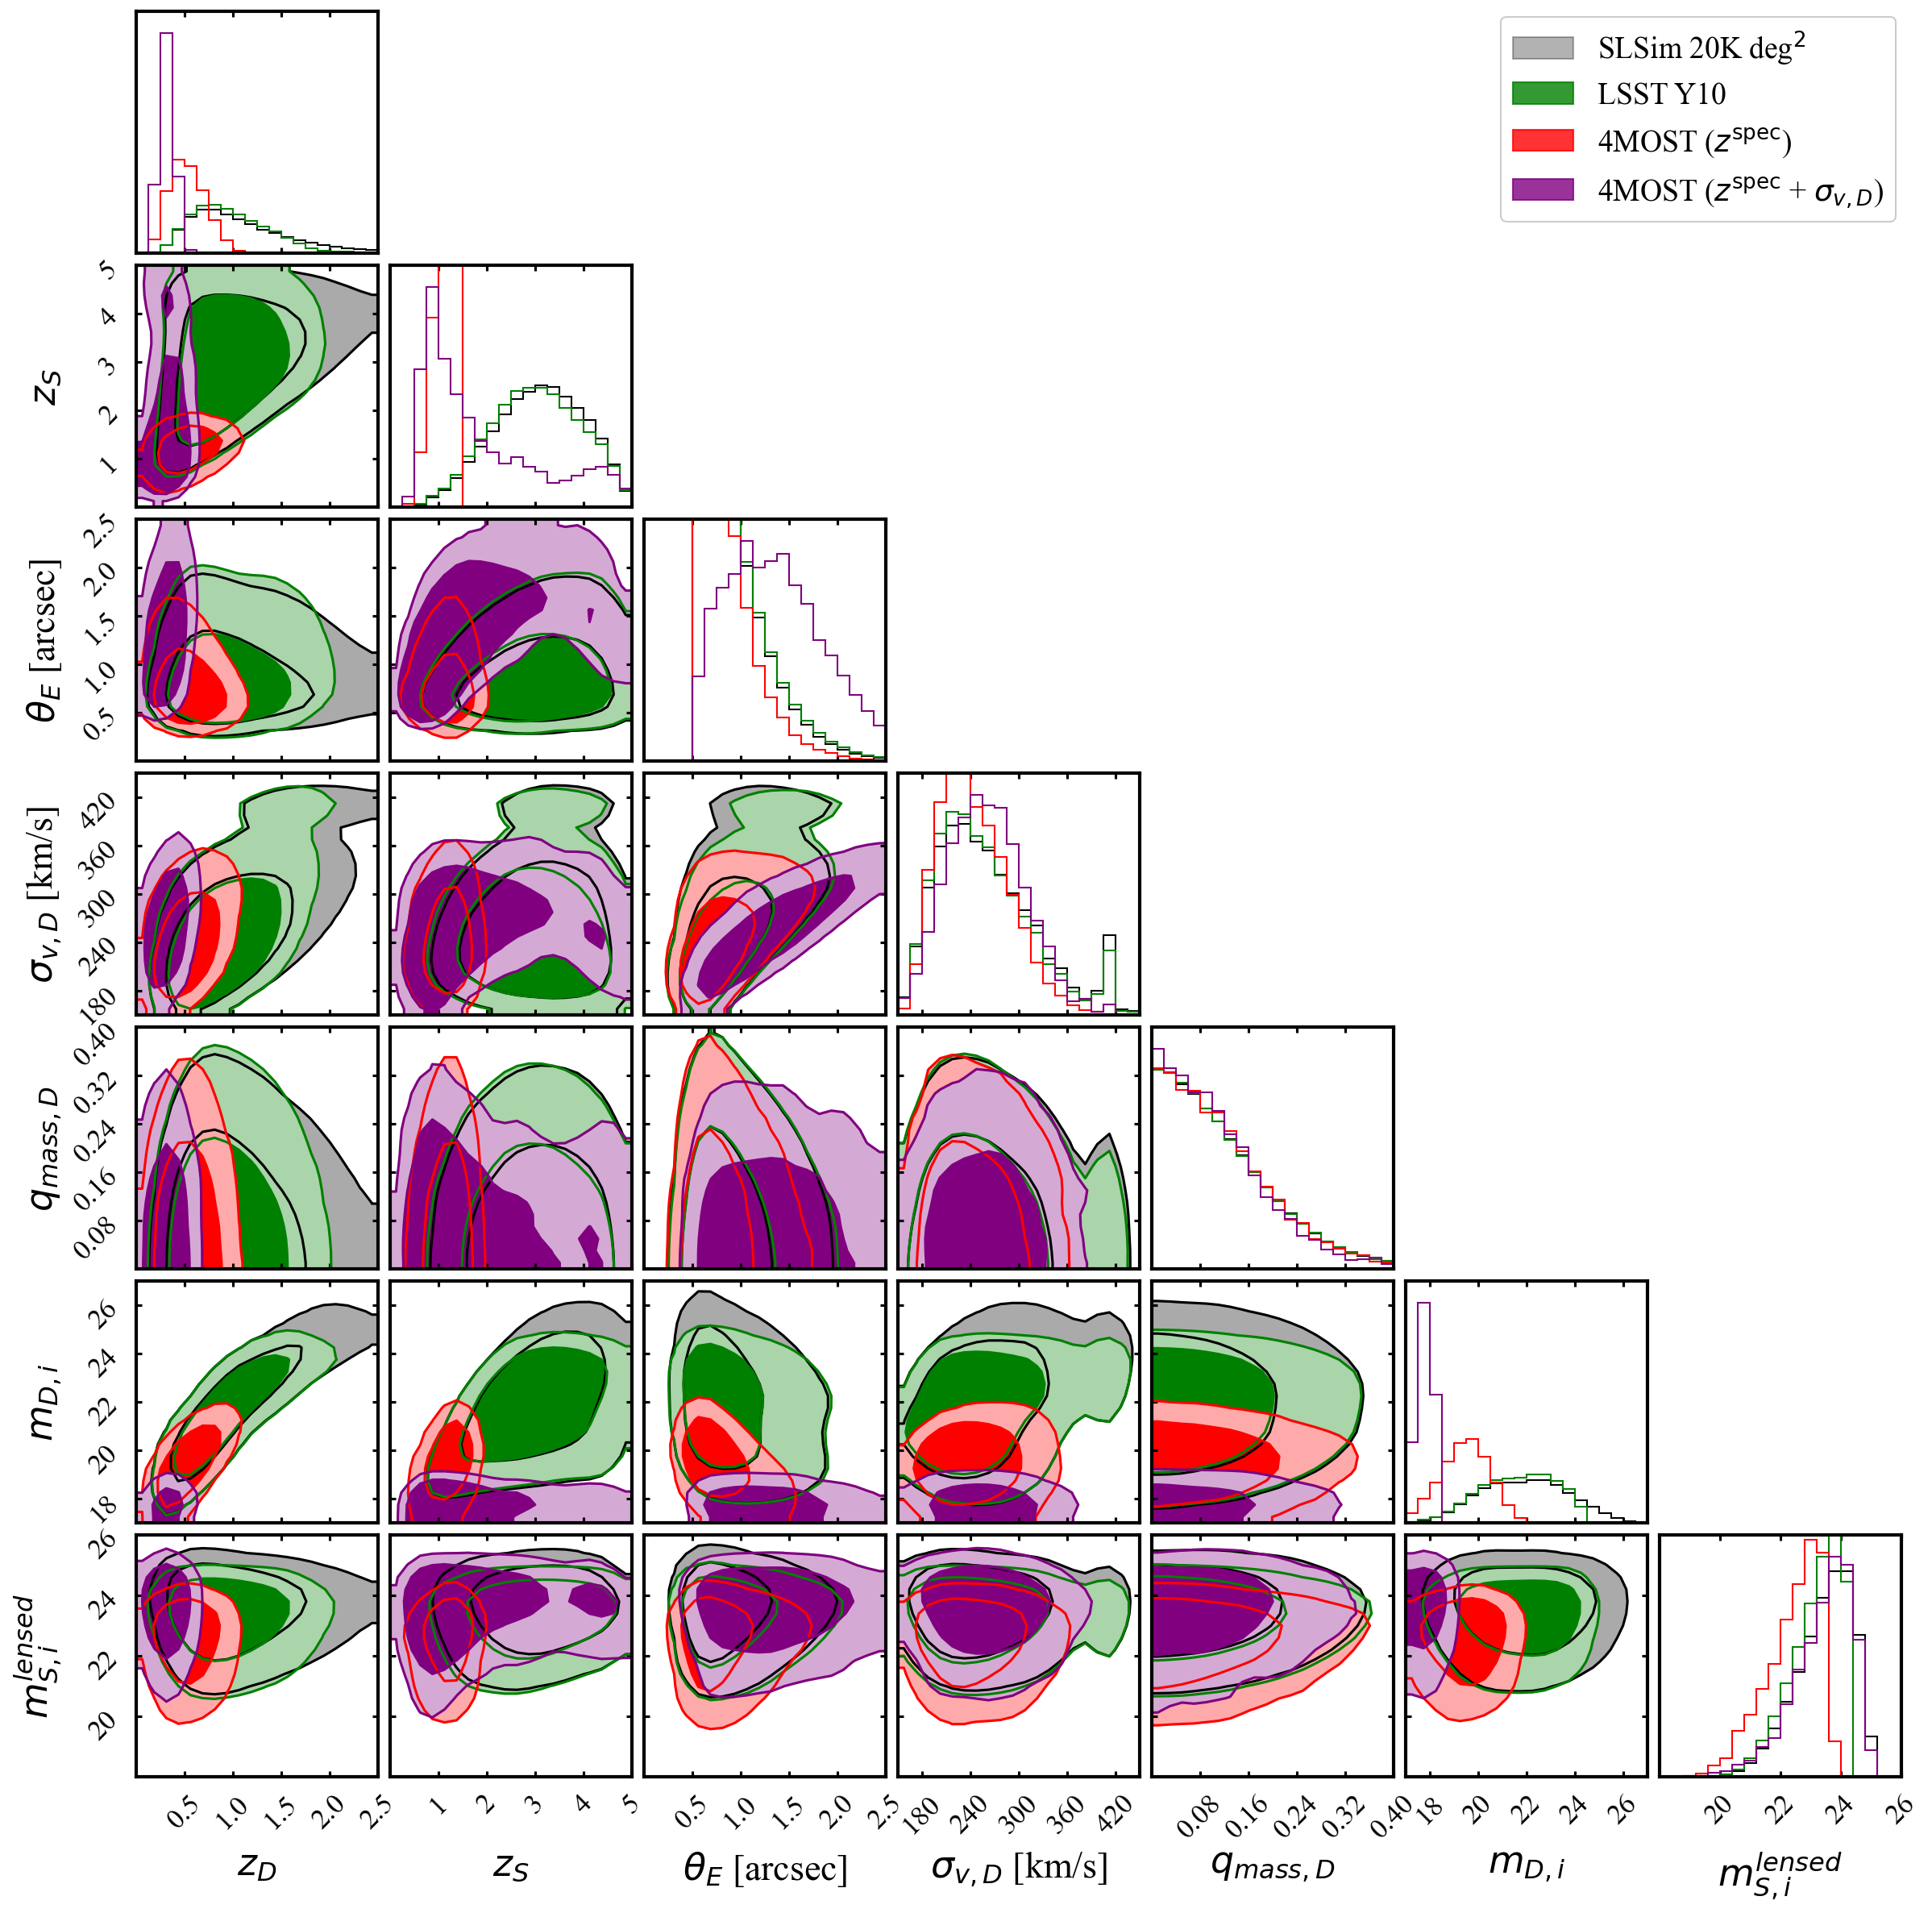

In [8]:
###################################################################
### Make corner plot of the Original and 3 depth cut data sets
###################################################################

samples_to_plot = ['lsst_y10', 'lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']

key_list = ['z_D',
            'z_S',
            'theta_E',
            'sigma_v_D',
            'e_mass_D',
            'mag_D_i', 
            'mag_S_i_lensed']
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    'theta_E': r'$\theta_E$ [arcsec]',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
    'e_mass_D': r'$q_{mass, D}$',
    'mag_D_i': r'$m_{D, i}$',
    'mag_S_i_lensed': r'$m_{S, i}^{lensed}$',
}

# --- Define plot ranges based on the reference image ---
plot_ranges = [
    (0.0, 2.5),  # z_D
    (0.0, 5.0),  # z_S
    (0.0, 2.5),  # theta_E
    (150, 450),  # sigma_v_D
    (0, 0.4),  # e_mass_D
    (17, 27),    # mag_D_i
    (18, 26)     # mag_S_i_lensed
]


data_corner_ref = [GGL_data_table[key] for key in key_list]
data_corner_ref = np.array(data_corner_ref).T

fig_corner_ref = corner.corner(
    data_corner_ref,
    labels=[key_latex_labels[key] for key in key_list],
    range=plot_ranges, 
    hist_kwargs={"density": True},
    smooth=1,
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.68, 0.95),
);

for sample_key in samples_to_plot:
    data_corner_sample = [pdspl_samples[sample_key]['table'][key] for key in key_list]
    data_corner_sample = np.array(data_corner_sample).T

    corner.corner(
        data_corner_sample,
        labels=[key_latex_labels[key] for key in key_list],
        range=plot_ranges, 
        hist_kwargs={"density": True},
        color=pdspl_samples[sample_key]['color'],
        smooth=1,
        fig=fig_corner_ref,
        plot_datapoints=False,
        fill_contours=True,
        levels=(0.68, 0.95)
    );


# fig_corner_ref.legend(
#     ['SLSim 20000 deg$^2$'] +
#     [pdspl_samples[sample_key]['name'] for sample_key in samples_to_plot],
#     loc='upper right',
#     fontsize=20  # Increased legend font size
# )
legend_handles = []

# 1. Add Reference Handle (Grey Patch)
legend_handles.append(mpatches.Patch(color='black', alpha=0.3, label='SLSim 20K deg$^2$'))
# legend_handles.append(mlines.Line2D([], [], color='black', label='_nolegend_')) # Outline trick

# 2. Add Sample Handles
for sample_key in samples_to_plot:
    color = pdspl_samples[sample_key]['color']
    name = pdspl_samples[sample_key]['name']
    
    # We combine a transparent patch (fill) and a solid line (outline) for the legend
    patch = mpatches.Patch(color=color, alpha=0.8, label=name)
    legend_handles.append(patch)

# Add the legend to the figure (placing it in the upper right empty space)
fig_corner_ref.legend(
    handles=legend_handles,
    loc='upper right',
    bbox_to_anchor=(0.98, 0.98), # Adjust these coordinates to move the box
    fontsize=18,
    frameon=True, 
    facecolor='white',
    framealpha=1.0
)

# make the font size of the labels and titles larger
for ax in fig_corner_ref.get_axes():
    # Increase tick label size and add padding
    ax.tick_params(axis='both', which='major', labelsize=17, pad=8)
    
    # Increase axis label size
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)
    
    # Increase title size (for 1D histograms)
    ax.title.set_size(22)

# fig_corner.savefig(f"../figures/slsim_corner_GGL_all_samples.png", bbox_inches='tight', dpi=300)
# fig_corner_ref.savefig(f"../figures/slsim_corner_GGL_all_samples.pdf", bbox_inches='tight', dpi=300)

In [21]:
# --- Cosmology used in SLSim ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [22]:
########################################################
### Pairing Properties and Titles
########################################################

# --- Deflector properties used for pairing ---
keys_to_pair_deflectors = [
    'z_D',
    'R_e_arcsec',
    'mag_D_i',
    'color_D_gr',
    'color_D_ri',
]

keys_to_pair_deflectors_latex = {
    'z_D': r'$z_{\mathrm{lens}}$',
    'R_e_kpc': r'$R_e$ [kpc]',
    'R_e_arcsec': r'$R_e$ [arcsec]',
    'mag_D_i': r'$m_i$',
    'color_D_gr': r'$m_g - m_r$',
    'color_D_ri': r'$m_r - m_i$',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
} 

# assign pairing keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        pairing_keys = ['z_D', 'R_e_arcsec', 'sigma_v_D']
    else:
        pairing_keys = keys_to_pair_deflectors

    s['pairing_keys'] = pairing_keys
    s['pairing_title'] = "Paired w/ kD-Tree in " + ", ".join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )
    s['pairing_keys_latex'] = ', '.join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )

########################################################
## Adding errors on z_D and sigma_v_D and R_e_arcsec
##########################################################

for sample_key in pdspl_samples.keys():

    # z_D errors
    if sample_key in ['lsst_single_visit', 'lsst_y10']:    
        z_D_error = 0.03 * (1 + pdspl_samples[sample_key]['table']['z_D'])  # photometric redshift error from LSST Science Book
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)
    elif sample_key in ['lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']:
        z_D_error = 1e-4 # spectroscopic redshift error
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)  
    else:
        z_D_error = 0
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D']
    
    # sigma_v_D errors
    if sample_key == 'lsst_4most_spec-z_sigma_v':
        sigma_v_error = 10.0  # fixed 10 km/s error on sigma_v_D [https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.5311L/abstract]
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D'] + np.random.normal(loc=0, scale=sigma_v_error)
    else:
        sigma_v_error = 0
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D']

    # R_e errors => 5-10% error on R_e
    R_e_error = 0.05 * (pdspl_samples[sample_key]['table']['R_e_arcsec'])
    sample_R_e_arcsec_with_errors = pdspl_samples[sample_key]['table']['R_e_arcsec'] + np.random.normal(loc=0, scale=R_e_error)

    # add these errors to a new table
    pdspl_samples[sample_key]['table_with_errors'] = pdspl_samples[sample_key]['table'].copy()
    pdspl_samples[sample_key]['table_with_errors']['z_D'] = sample_z_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['sigma_v_D'] = sample_sigma_v_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['R_e_arcsec'] = sample_R_e_arcsec_with_errors

    pdspl_samples[sample_key]['table_with_errors']['err_z_D'] = z_D_error
    pdspl_samples[sample_key]['table_with_errors']['err_sigma_v_D'] = sigma_v_error
    pdspl_samples[sample_key]['table_with_errors']['err_R_e_arcsec'] = R_e_error

########################################################

########################################################
## define dissimilarity estimator parameters for each sample
##########################################################
# --- Define which parameters to include in the dissimilarity estimator ---
keys_to_use_for_dissimilarity = [
    "rel_diff_R_e_arcsec",
    "rel_diff_z_D",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- (optional) Define pretty LaTeX labels for each key ---
key_latex_map = {
    "rel_diff_R_e_arcsec": r"\frac{\Delta R_e}{R_e}",
    "rel_diff_z_D": r"\frac{\Delta z_D}{z_D}",
    "rel_diff_mag_D_i": r"\frac{\Delta m_i}{m_i}",
    "rel_diff_color_D_gr": r"\frac{\Delta c_{gr}}{c_{gr}}",
    "rel_diff_color_D_ri": r"\frac{\Delta c_{ri}}{c_{ri}}"
}

# assign dissimilarity keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        dissimilarity_keys = [
            "rel_diff_z_D",
            "rel_diff_R_e_arcsec",
            "rel_diff_sigma_v_D"
        ]
    else:
        dissimilarity_keys = keys_to_use_for_dissimilarity

    s['dissimilarity_keys'] = dissimilarity_keys
############################################################

In [23]:
########################################################
###  Get pairs table for each LSST sample
########################################################

for sample_key, s in pdspl_samples.items():
    table = s["table"]

    if len(table) < 2:
        print(f"⚠️ Skipping {sample_key}: too few lenses ({len(table)})")
        continue

    # print(f"\nBuilding full pairs table for {s['name']} ...")

    pairing_keys = s['pairing_keys']
    pairing_title = s['pairing_title']

    # Normalized feature space, use table with errors for pairing
    points = np.stack(
        [normalize_data(s['table_with_errors'][pk], type='zscore') for pk in pairing_keys],
        axis=1
    )

    # Pair with KD-tree
    indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)

    # Build pairs table from kD-tree indices
    pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true)
    pairs_table_with_errors = get_pairs_table_PDSPL(s['table_with_errors'], pair_indices=indices, cosmo=cosmo_true)

    # Compute summary stats
    num_lenses = len(table)
    num_pairs = len(pairs_table)
    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"]
    scatter_in_beta_E = np.std(1 - beta_ratio)
    mean_beta_ratio = np.mean(beta_ratio)
    median_beta_ratio = np.median(beta_ratio)

    # Store results inside the sample dict
    s["pairs_analysis"] = {
        "pairs_table": pairs_table,
        "pairs_table_with_errors": pairs_table_with_errors,
        "num_lenses": num_lenses,
        "num_pairs": num_pairs,
        "scatter_in_beta_E": scatter_in_beta_E,
        "mean_beta_ratio": mean_beta_ratio,
        "median_beta_ratio": median_beta_ratio,
        "pairing_keys": pairing_keys,
        "pairing_title": pairing_title,
        "pairing_points": points,
    }

    print(f"✅ {s['name']}: {num_pairs} pairs, scatter = {scatter_in_beta_E:.4f}")

########################################################
###  Find dissimilarity estimator for each LSST sample and attach to pairs table
########################################################
for sample_key, s in pdspl_samples.items():
    pairs_table_with_errors = s["pairs_analysis"]["pairs_table_with_errors"]
    diffs = np.array([pairs_table_with_errors[k] for k in s['dissimilarity_keys']])
    dissimilarity_estimator = np.sqrt(np.mean(diffs**2, axis=0))
    s["pairs_analysis"]["pairs_table_with_errors"]['dissimilarity'] = dissimilarity_estimator
########################################################

Processing pairs: 100%|██████████| 106251/106251 [00:20<00:00, 5255.72it/s]


✅ LSST Y10: 106251 pairs, scatter = 0.1893


Processing pairs: 100%|██████████| 3667/3667 [00:00<00:00, 5366.52it/s]


✅ 4MOST ($z^{\rm spec}$): 3667 pairs, scatter = 0.1217


Processing pairs: 100%|██████████| 1771/1771 [00:00<00:00, 5208.42it/s]

✅ 4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$): 1771 pairs, scatter = 0.0470


In [ ]:
# load the pdspl_samples object with pickle
# with open('../data/samples/pdspl_samples_with_pairs.pkl', 'rb') as f:
#     pdspl_samples = pickle.load(f)

LSST Y10: scatter vs dissimilarity fit: slope = 0.265, intercept = -0.337
4MOST ($z^{\rm spec}$): scatter vs dissimilarity fit: slope = 0.425, intercept = -0.267
4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$): scatter vs dissimilarity fit: slope = 0.453, intercept = -0.600


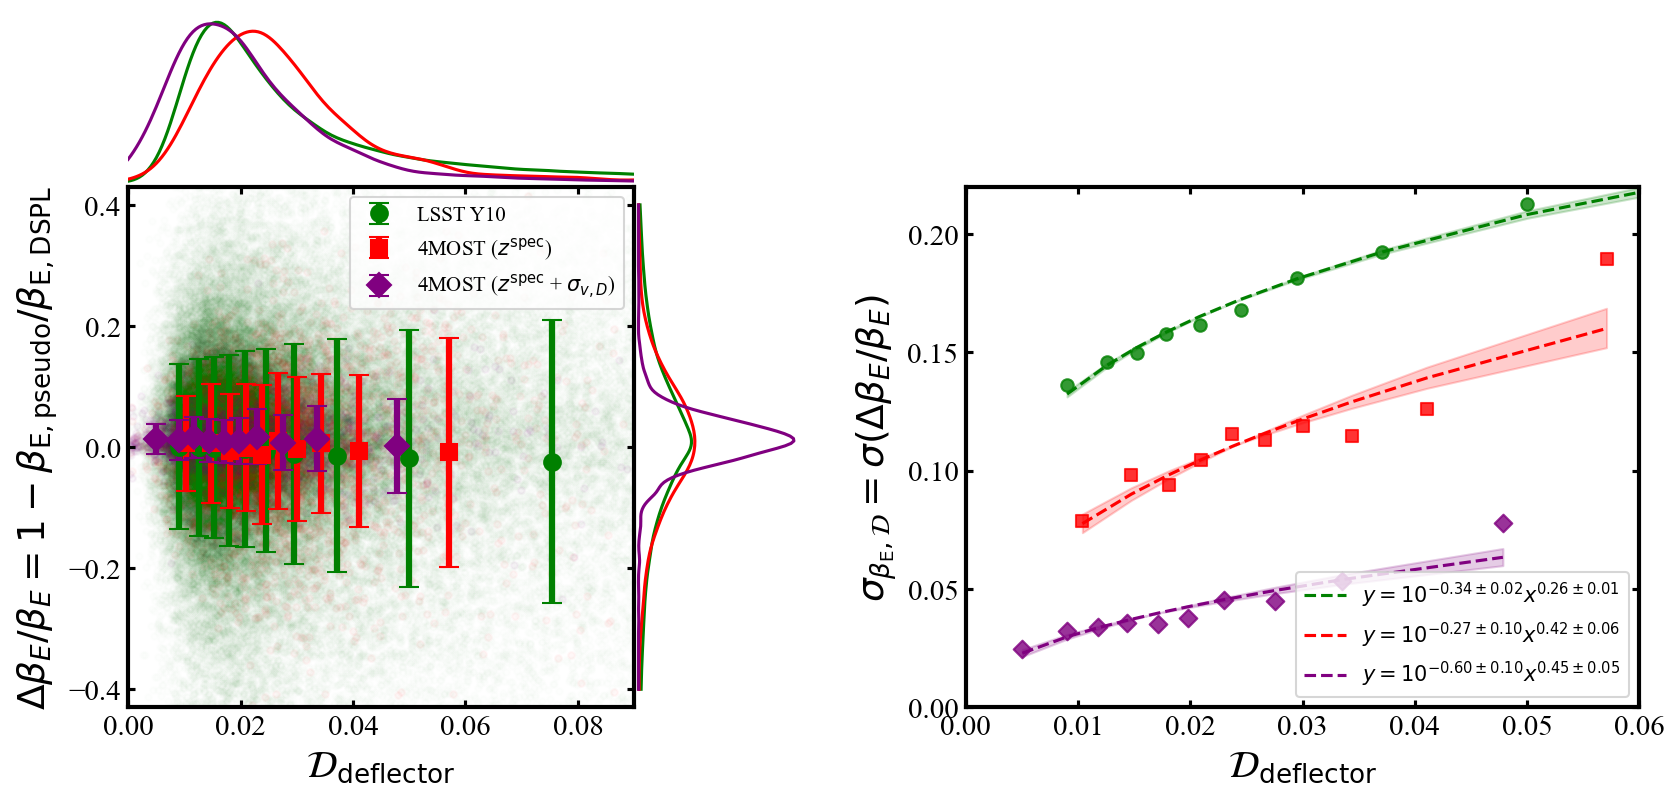

In [24]:
########################################
### scatter_beta_E as a function of dissimilarity
########################################

alpha_vals = {
    "lsst_y10": 0.007,
    "lsst_4most_spec-z": 0.03,
    "lsst_4most_spec-z_sigma_v": 0.04,
}

markers = {
    "lsst_y10": "o",
    "lsst_4most_spec-z": "s",
    "lsst_4most_spec-z_sigma_v": "D",
}

# --- Set up figure layout
fig = plt.figure(figsize=(13, 6))
gs = GridSpec(4, 9, figure=fig, wspace=-0.02, hspace=-0.02,
              )

ax_scatter = fig.add_subplot(gs[1:, 0:3])
ax_histx   = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1:, 3], sharey=ax_scatter)
ax_fit = fig.add_subplot(gs[1:, 5:9])

ignore_keys = [
    # 'lsst_4most_spec-z',
    # 'lsst_4most_spec-z_sigma_v'
]

# --- Loop through samples
for sample_key, s in pdspl_samples.items() :
    if sample_key in ignore_keys:
        continue
    tbl_err = s["pairs_analysis"]["pairs_table_with_errors"]
    tbl = s["pairs_analysis"]["pairs_table"]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    # limit to dissimilarity < 0.1 for better visualization
    mask = (tbl_err['dissimilarity'] < 0.1) & (np.isfinite(delta_beta_E))
    tbl_err = tbl_err[mask]
    tbl = tbl[mask]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    # Scatter
    ax_scatter.scatter(
        dissimilarities,
        delta_beta_E,
        color=s['color'],
        alpha=alpha_vals[sample_key],
        s=10,
    )

    # Histograms
    # ax_histx.hist(dissimilarities, bins=40, color=s['color'], histtype='step',
    #               density=True)
    # ax_histy.hist(delta_beta_E, bins=40, color=s['color'], orientation='horizontal', histtype='step',
    #               density=True)
    
    # --- KDE smoothed histograms
    kde_x = gaussian_kde(dissimilarities)
    kde_y = gaussian_kde(delta_beta_E)
    x_grid = np.linspace(0, 0.1, 200)
    y_grid = np.linspace(-0.4, 0.4, 200)
    ax_histx.plot(x_grid, kde_x(x_grid), color=s['color'], lw=1.5)
    ax_histy.plot(kde_y(y_grid), y_grid, color=s['color'], lw=1.5)

    
    # bin the dissimilarities, using percentiles, use np.digitize to bin
    percentiles = np.percentile(dissimilarities, np.arange(0, 101, 10))
    digitized = np.digitize(dissimilarities, percentiles)

    binned_dissimilarities = []
    binned_scatter_beta_E = []
    binned_means_beta_E = []

    for i in range(1, len(percentiles)):
        bin_mask = digitized == i
        if np.sum(bin_mask) > 0:
            binned_dissimilarities.append(np.median(dissimilarities[bin_mask]))
            scatter_in_beta_E = np.nanstd(delta_beta_E[bin_mask])
            binned_scatter_beta_E.append(scatter_in_beta_E)
            binned_means_beta_E.append(np.nanmean(delta_beta_E[bin_mask]))

    # on the original scatter plot, plot the binned means +- scatter
    ax_scatter.errorbar(
        binned_dissimilarities,
        binned_means_beta_E,
        yerr=binned_scatter_beta_E,
        fmt=markers[sample_key],
        color=s['color'],
        markersize=8,
        # markeredgecolor='k',
        label=s['name'],
        capsize=5,
        elinewidth=3,
    )

    # plot the binned scatter vs binned dissimilarity
    ax_fit.scatter(
        binned_dissimilarities,
        binned_scatter_beta_E,
        marker=markers[sample_key],
        color=s['color'],
        # label=s['name'],
        alpha=0.8,
    )
    
    # fit a line in log-log space, use covariance matrix to get uncertainties
    coeffs, cov = np.polyfit(np.log10(np.array(binned_dissimilarities)), 
                            np.log10(np.array(binned_scatter_beta_E)), 1, cov=True)
    
    # fit equation latex
    fit_eq_latex = r"$y = 10^{%.2f \pm %.2f} x^{%.2f \pm %.2f}$" % (
        coeffs[1], np.sqrt(cov[1, 1]),
        coeffs[0], np.sqrt(cov[0, 0])
    )

    # fitted line and 1-sigma uncertainty region
    ax_fit.plot(
        np.array(binned_dissimilarities),
        10**(np.polyval(coeffs, np.log10(np.array(binned_dissimilarities)))),
        linestyle='--',
        color=s['color'],
        label = fit_eq_latex
    )
    ax_fit.fill_between(
        np.array(binned_dissimilarities),
        10**(np.polyval(coeffs - np.sqrt(np.diag(cov)), np.log10(np.array(binned_dissimilarities)))),
        10**(np.polyval(coeffs + np.sqrt(np.diag(cov)), np.log10(np.array(binned_dissimilarities)))),
        color=s['color'],
        alpha=0.2,
    )

    # attach the fitted coeffs to the sample dict
    s['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs'] = coeffs
    s['pairs_analysis']['scatter_vs_dissimilarity_fit_cov'] = cov

    # print the fit results
    print(f"{s['name']}: scatter vs dissimilarity fit: slope = {coeffs[0]:.3f}, intercept = {coeffs[1]:.3f}")
    

# --- Labels, limits, etc.
ax_scatter.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_scatter.set_ylabel(r"$\Delta \beta_{E} / \beta_{E} = 1 - \beta_{\rm E, pseudo}/\beta_{\rm E, DSPL}$")
ax_scatter.set_xlim(0, 0.09)
ax_scatter.set_ylim(-0.43, 0.43)
ax_scatter.legend(frameon=True)

# --- Hide axis for the marginal histograms
ax_histx.axis('off')
ax_histy.axis('off')


# --- Fit panel axis labels
ax_fit.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_fit.set_ylabel(r"$\sigma_{\beta_{\rm E},\rm \mathcal{D}} = \sigma(\Delta \beta_{E} / \beta_{E})$")
ax_fit.set_xlim(0, 0.06)
ax_fit.set_ylim(0, 0.22)
ax_fit.legend(frameon=True)


# --- Save figure
# fig.savefig(f"../figures/beta_E_vs_D.png", dpi=300, bbox_inches='tight')


In [ ]:
# save the pdspl_samples object with pickle
# with open('../data/samples/pdspl_samples_with_pairs.pkl', 'wb') as f:
#     pickle.dump(pdspl_samples, f)

In [20]:
########################################################
## Latex Table 1: Summary of all samples
## Columns: Sample, # Lenses, Selection Criteria
########################################################

print("Latex Table 1: Summary of all samples\n")

print(r"\begin{tabular}{l c c}")
print(r"\hline")
print(r"\textbf{Sample} & \textbf{\# Lenses} & \textbf{Selection Criteria}\\")
print(r"\hline")

# Main SLSim entry (spanning two rows)
print(
    f"\\multirow{{2}}{{*}}{{SLSim 20000 deg$^2$}} & "
    f"\\multirow{{2}}{{*}}{{{len(GGL_data_table)}}} & "
    + "$m_{i} < 28.0$, $\\mu_{\\rm tot} > 3$, $1'' < \\Delta \\theta < 8''$ \\\\"
)
print(r" & & contrast ratio $> 2$, $m_{i}^{\rm 2^{\rm nd} \ brightest} < 26$\\\\")

# Other samples
for key, s in pdspl_samples.items():
    print(f"{s['name']} & {s['count']} & {s['selc_func_latex']} \\\\")

print(r"\hline")
print(r"\end{tabular}")
########################################################


########################################################
## Latex Table 2: Pairing parameters per sample
## Columns: Sample, Pairing Parameters
########################################################

print("\nLatex Table 2: Pairing Parameters\n")

print(r"\begin{tabular}{l c}")
print(r"\hline")
print(r"\textbf{Sample} & \textbf{Pairing Parameters}\\")
print(r"\hline")

# Loop through paired samples
for key, s in pdspl_samples.items():
    print(f"{s['name']} & {s['pairing_keys_latex']} \\\\")

print(r"\hline")
print(r"\end{tabular}")
########################################################

########################################################
## Latex Table 3: Number of pairs and scatter_beta_E vs dissimilarity fit parameters
########################################################
print("\nLatex Table 3: Summary of Pairing Analysis Results\n")

keys_to_plot = ["lsst_y10", 
                "lsst_4most_spec-z", 
                "lsst_4most_spec-z_sigma_v"]

print(r"\begin{tabular}{l | c c c | c c}")
print(r"\hline")
print(r"\multirow{2}{*}{\textbf{Sample}} & \multicolumn{3}{c|}{\textbf{Pairing at 20K deg$^2$}} & \multicolumn{2}{c}{\textbf{PL Fit}} \\")
print(r" & \textbf{\# Lenses} & \textbf{\# Pairs} & \textbf{${\Delta\beta_{\rm E}}/{\beta_{\rm E}}$} & \textbf{a} & \textbf{b} \\")
print(r"\hline")

# Loop through paired samples
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        continue
    pa = s["pairs_analysis"]
    fit_coeffs = s['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs']
    fit_covs = s['pairs_analysis']['scatter_vs_dissimilarity_fit_cov']
    a = fit_coeffs[0]
    b = fit_coeffs[1]
    da = np.sqrt(fit_covs[0, 0])
    db = np.sqrt(fit_covs[1, 1])
    
    print(
        f"{s['name']} & "
        f"{pa['num_lenses']} & "
        f"{pa['num_pairs']} & "
        f"{pa['scatter_in_beta_E']:.2f} & "
        f"{a:.2f} $\\pm$ {da:.2f} & "
        f"{b:.2f} $\\pm$ {db:.2f} \\\\"
    )

print(r"\hline")
print(r"\end{tabular}")
########################################################


Latex Table 1: Summary of all samples

\begin{tabular}{l c c}
\hline
\textbf{Sample} & \textbf{\# Lenses} & \textbf{Selection Criteria}\\
\hline
\multirow{2}{*}{SLSim 20000 deg$^2$} & \multirow{2}{*}{310308} & $m_{i} < 28.0$, $\mu_{\rm tot} > 3$, $1'' < \Delta \theta < 8''$ \\
 & & contrast ratio $> 2$, $m_{i}^{\rm 2^{\rm nd} \ brightest} < 26$\\\\
LSST Y10 & 144068 & $m_{i} < 25.8, R_e > 0.7''$ \\
4MOST ($z^{\rm spec}$) & 5038 & $m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$ \\
4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$) & 2519 & $m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$ \\
\hline
\end{tabular}

Latex Table 2: Pairing Parameters

\begin{tabular}{l c}
\hline
\textbf{Sample} & \textbf{Pairing Parameters}\\
\hline
LSST Y10 & $z_{\mathrm{lens}}$, $R_e$ [arcsec], $m_i$, $m_g - m_r$, $m_r - m_i$ \\
4MOST ($z^{\rm spec}$) & $z_{\mathrm{lens}}$, $R_e$ [arcsec], $m_i$, $m_g - m_r$, $m_r - m_i$ \\
4MOST ($z^{\rm spec}$ + $\sigma_{v, D}$) & $z_{\mathrm{lens}}$, $R_e$ [arcsec], $\sigma_{v, D}$ [km/s] \\
\hline

Plotting for LSST Y10 ($i < 25.8$) with 106251 pairs
Plotting for 4MOST ($r < 24, z_S < 1.5$) with 3667 pairs
Plotting for 4MOST ($r < 24, z_S < 1.5$) with 1771 pairs


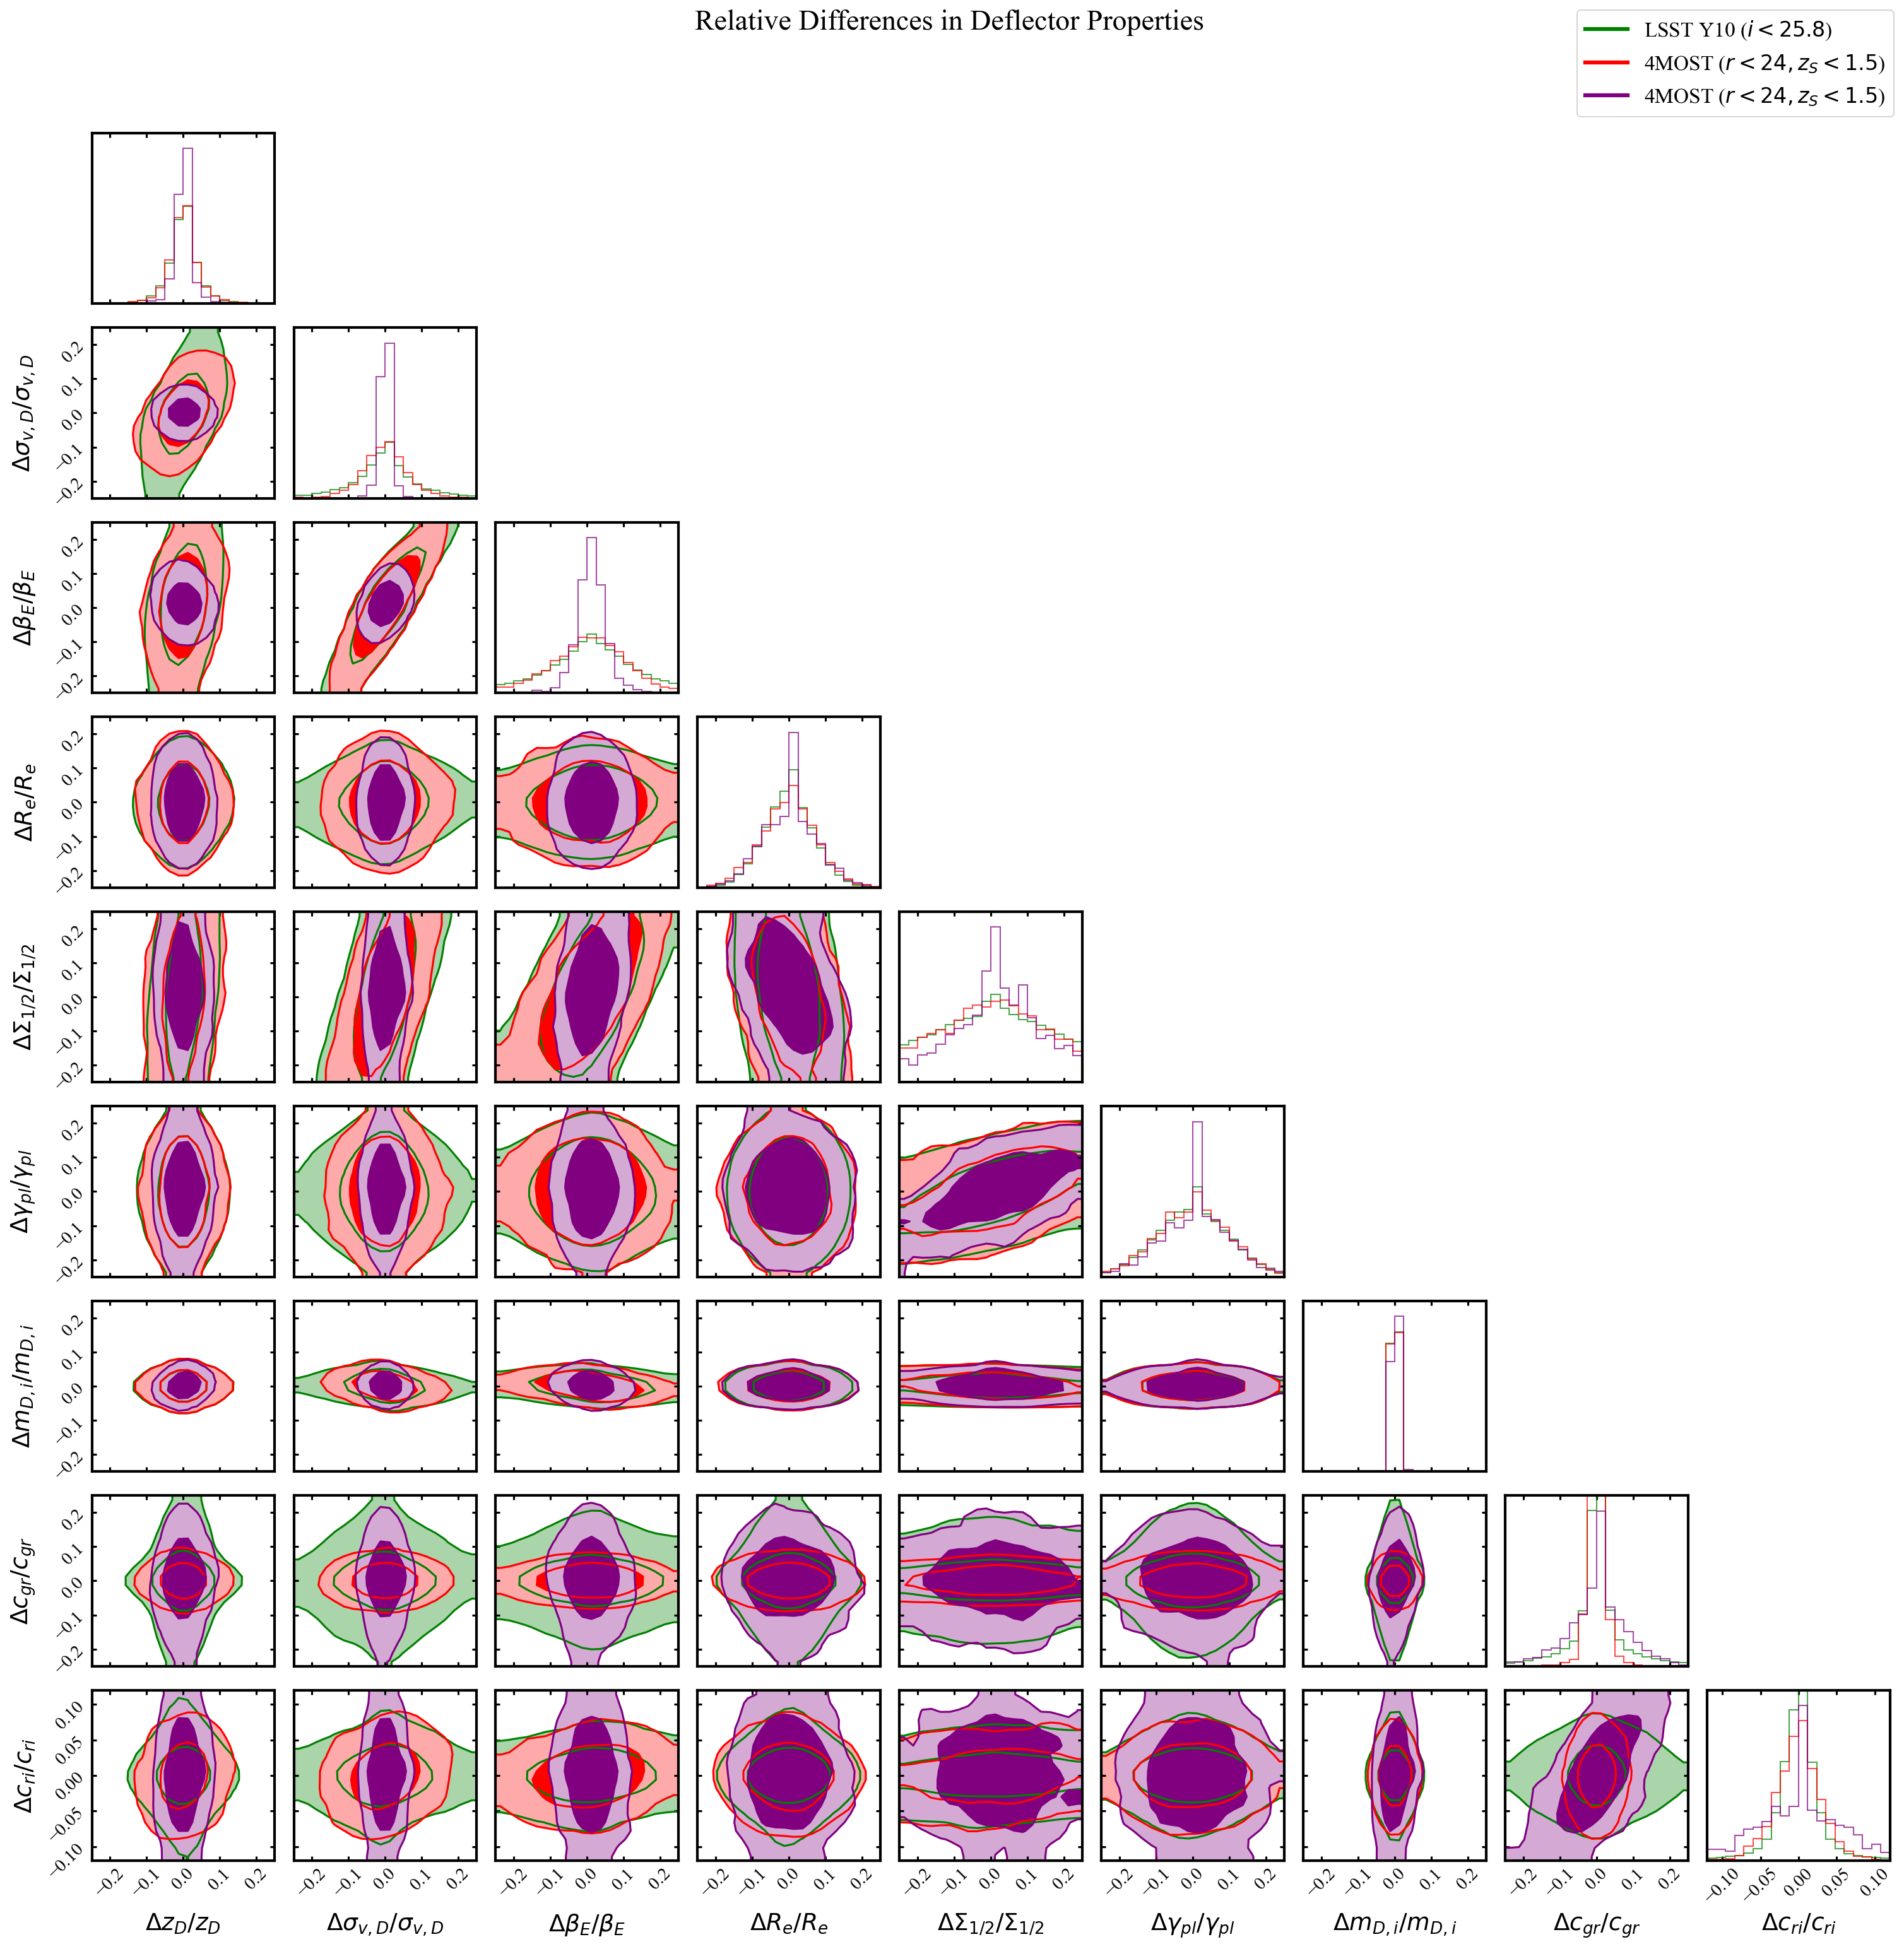

In [29]:
########################################################
###  Corner Plot for Deflector Pair Differences
########################################################

# --- Define which relative-difference parameters to include ---
keys_to_use_for_corner = [
    "rel_diff_z_D",
    "rel_diff_sigma_v_D",
    "rel_diff_beta_E",
    "rel_diff_R_e_arcsec",
    "rel_diff_Sigma_half",
    "rel_diff_gamma_pl",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- Define LaTeX labels dynamically for corner axes ---
key_latex_map = {
    "rel_diff_z_D":        r"$\Delta z_{D} / z_{D}$",
    "rel_diff_sigma_v_D":  r"$\Delta \sigma_{v,D} / \sigma_{v,D}$",
    "rel_diff_beta_E":     r"$\Delta \beta_{E} / \beta_{E}$",
    "rel_diff_R_e_arcsec": r"$\Delta R_{e} / R_{e}$",
    "rel_diff_Sigma_half": r"$\Delta \Sigma_{1/2} / \Sigma_{1/2}$",
    "rel_diff_gamma_pl":   r"$\Delta \gamma_{pl} / \gamma_{pl}$",
    "rel_diff_mag_D_i":    r"$\Delta m_{D,i} / m_{D,i}$",
    "rel_diff_color_D_gr": r"${\Delta c_{gr}} / {c_{gr}}$",
    "rel_diff_color_D_ri": r"${\Delta c_{ri}} / {c_{ri}}$"
}

corner_labels = [key_latex_map[k] for k in keys_to_use_for_corner]

# --- Which samples to plot ---
samples_to_plot = [
                    # "lsst_single_visit", 
                   "lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

# --- Plotting ---
figure = None  # will hold combined corner plot

for key in samples_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        print(f"⚠️ Skipping {s['label']} (no pairs_analysis found)")
        continue

    pairs_table = s["pairs_analysis"]["pairs_table"]

    if len(pairs_table) == 0:
        print(f"⚠️ Skipping {s['label']} (no pairs found)")
        continue

    print(f"Plotting for {s['label']} with {len(pairs_table)} pairs")

    # --- Build corner data array dynamically ---
    corner_data = np.vstack([pairs_table[k] for k in keys_to_use_for_corner]).T

    figure = corner.corner(
        corner_data,
        labels=corner_labels,
        color=s["color"],
        fig=figure,                      # overlay all samples on same figure
        smooth=1.0,
        hist_kwargs={"density": True, "alpha": 0.7},
        plot_density=True,
        plot_datapoints=False,
        show_titles=False,
        fill_contours=True,
        levels=(0.68, 0.95),
        label_kwargs={"fontsize": 18},
        range=[(-0.25, 0.25)] * (len(keys_to_use_for_corner) - 1) + [(-0.12, 0.12)],
    )

# --- Add legend manually ---
handles = [
    plt.Line2D([], [], color=pdspl_samples[k]["color"], lw=3, label=pdspl_samples[k]["label"])
    for k in samples_to_plot
]
figure.legend(handles=handles, loc="upper right", fontsize=16)

# --- Title & layout ---
figure.suptitle(
    f"Relative Differences in Deflector Properties\n",
    # f"({len(keys_to_use_for_corner)} parameters)",
    fontsize=22,
    y=1.02
)
figure.tight_layout()
plt.show()